In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA


from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
df=pd.read_csv('data/vehicles.csv')

In [5]:
# Drop Duplicates 
df = df.drop_duplicates()

# Drop if price = null 
df = df[df['price'].notnull()]

In [6]:
# Corelate price , year and odometer . 
df[['price','year','odometer']].corr()

,price,year,odometer
price,1.000000,-0.004925,0.010032
year,-0.004925,1.000000,-0.157215
odometer,0.010032,-0.157215,1.000000


###### From the above co-relation matrix ,There is no corelation between price , year and mileage. 

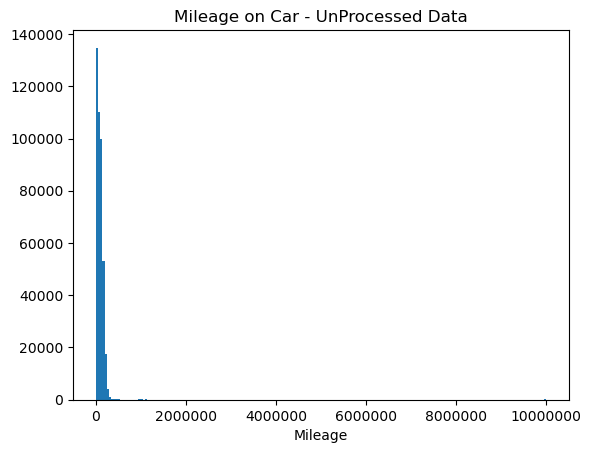

In [7]:
# Create histogram of Mileage on car 
plt.ticklabel_format(style='plain', axis='x') 
plt.hist(df['odometer'], bins=200)
plt.title("Mileage on Car - UnProcessed Data")
plt.xlabel("Mileage")
plt.savefig("./images/mileage_unprocessed.png", dpi=300)  
plt.show()

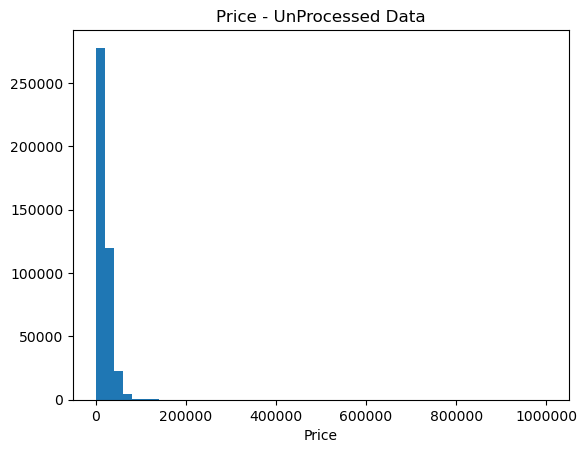

In [8]:
# Create histogram of Price of Car 
plt.ticklabel_format(style='plain', axis='x') 
plt.hist(df[df['price'] < 1000000]['price'], bins=50)
plt.title("Price - UnProcessed Data")
plt.xlabel("Price")
plt.savefig("./images/price_unprocessed.png", dpi=300)  
plt.show()

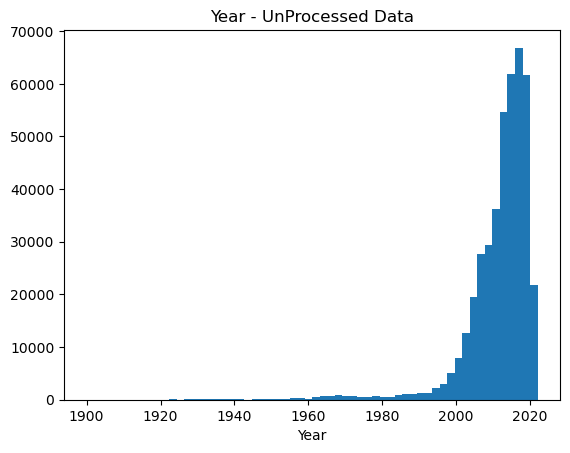

In [9]:
# Create histogram of Year of car 
plt.hist(df['year'], bins=60)
plt.title("Year - UnProcessed Data")
plt.xlabel("Year")
plt.savefig("./images/year_unprocessed.png", dpi=300)  
plt.show()

In [10]:
# Make sure numeric columns are actually numeric.

df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')

In [11]:
# Dropping null values for numeric values 
df = df.dropna(subset=['price', 'year', 'odometer'])

In [12]:
# Removing cars under $500 and over $100,000 
df = df[(df['price'] > 500) & (df['price'] < 100000)]

In [13]:
# Removing cars with < 100 and > 300K miles 
df = df[(df['odometer'] >= 100) & (df['odometer'] <= 300000)]

In [14]:
# Filtering impossible years 
df = df[(df['year'] >= 1980) & (df['year'] <= 2025)]

In [15]:
df

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
27,7316814884,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,NaN,NaN,pickup,white,al
28,7316814758,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,NaN,NaN,pickup,blue,al
29,7316814989,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,NaN,NaN,pickup,red,al
30,7316743432,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,NaN,NaN,pickup,red,al
31,7316356412,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,NaN,rwd,full-size,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy


In [16]:
# Lowercase and strip extra spaces:
cat_cols = ['manufacturer','model','condition','fuel','title_status',
            'transmission','drive','size','type','paint_color','state','region']

for col in cat_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

In [17]:
#Replace weird placeholders
df = df.replace(['unknown','other','nan','none',''], pd.NA)

In [18]:
# Create helpful new feature , car_age 
df['car_age'] = 2025 - df['year']

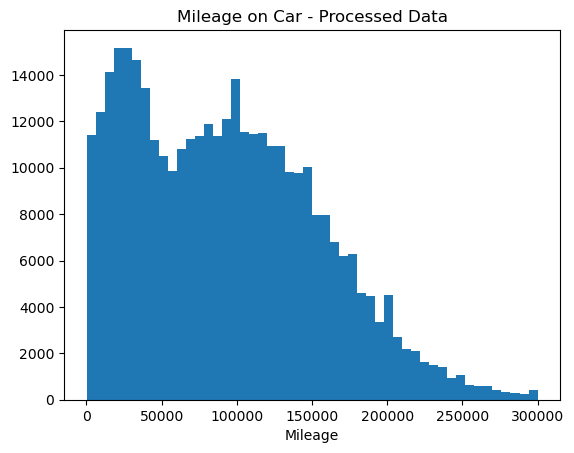

In [19]:
# Plotting Mileage on car with processed data. 

plt.hist(df['odometer'], bins=50)
plt.title("Mileage on Car - Processed Data")
plt.xlabel("Mileage")
plt.savefig("./images/mileage_processed.png", dpi=300)  
plt.show()

plt.show()

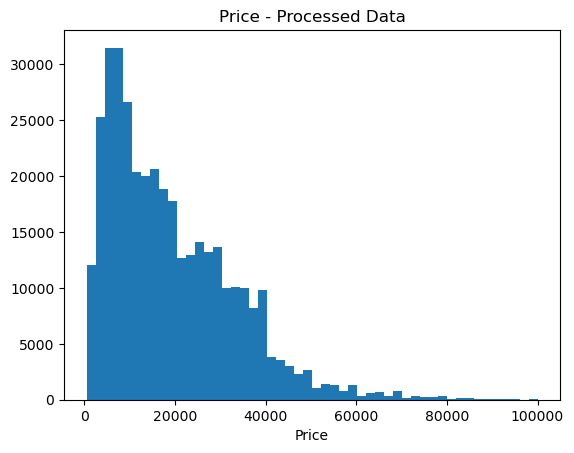

In [20]:
# Plotting Prise of car with processes data 

plt.ticklabel_format(style='plain', axis='x') 
plt.hist(df["price"], bins=50)

plt.title("Price - Processed Data")
plt.xlabel("Price")
plt.savefig("./images/price_processed.png", dpi=300)  
plt.show()

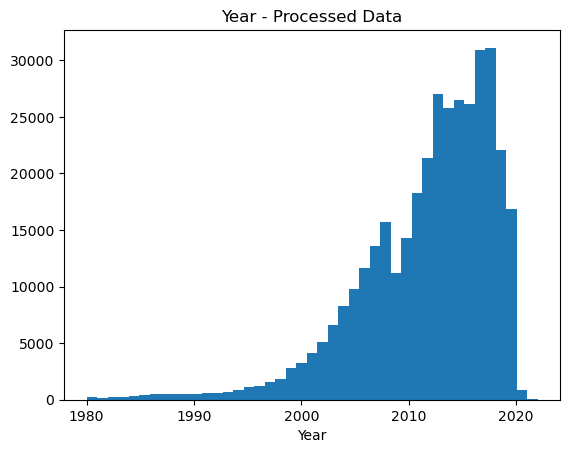

In [21]:
# PLotting year of car on processed data. 

plt.hist(df["year"], bins=43)
plt.title("Year - Processed Data")
plt.xlabel("Year")
plt.savefig("./images/year_processed.png", dpi=300)  
plt.show()

In [22]:
# Drop "id" and "VIN" columns as these are specific to car ,
# and do not have any significance in determining the prise of the car. 
df = df.drop(columns=['id' , 'VIN'])

In [23]:
# Dropping features to reduce the compute power . My PC could not handle more features. 

df_clean = df.drop(columns=['region', 'cylinders', 'model' , 'fuel' , 'transmission' , 'drive' , 'paint_color' , 'state' , 'size' , 'year'])
df_clean.to_csv('./data/df_clean.csv' , index=False)
df_clean

,price,manufacturer,condition,odometer,title_status,type,car_age
27,33590,gmc,good,57923.0,clean,pickup,11.0
28,22590,chevrolet,good,71229.0,clean,pickup,15.0
29,39590,chevrolet,good,19160.0,clean,pickup,5.0
30,30990,toyota,good,41124.0,clean,pickup,8.0
31,15000,ford,excellent,128000.0,clean,truck,12.0
...,...,...,...,...,...,...,...
426875,23590,nissan,good,32226.0,clean,sedan,6.0
426876,30590,volvo,good,12029.0,clean,sedan,5.0
426877,34990,cadillac,good,4174.0,clean,hatchback,5.0
426878,28990,lexus,good,30112.0,clean,sedan,7.0


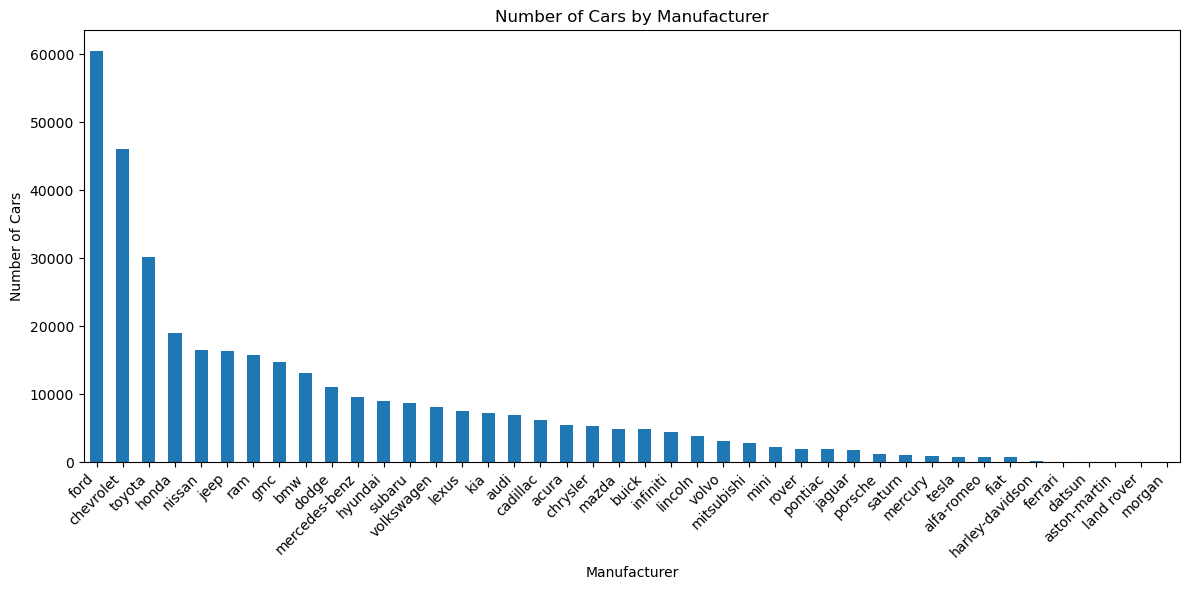

In [24]:
# Interesting statistics 
# Plotting number of cars vs manufacturer 


counts = df_clean['manufacturer'].value_counts()

# Plot
plt.figure(figsize=(12,6))
counts.plot(kind='bar')

plt.xlabel("Manufacturer")
plt.ylabel("Number of Cars")
plt.title("Number of Cars by Manufacturer")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("./images/cars_manufacturer.png", dpi=300)
plt.show()

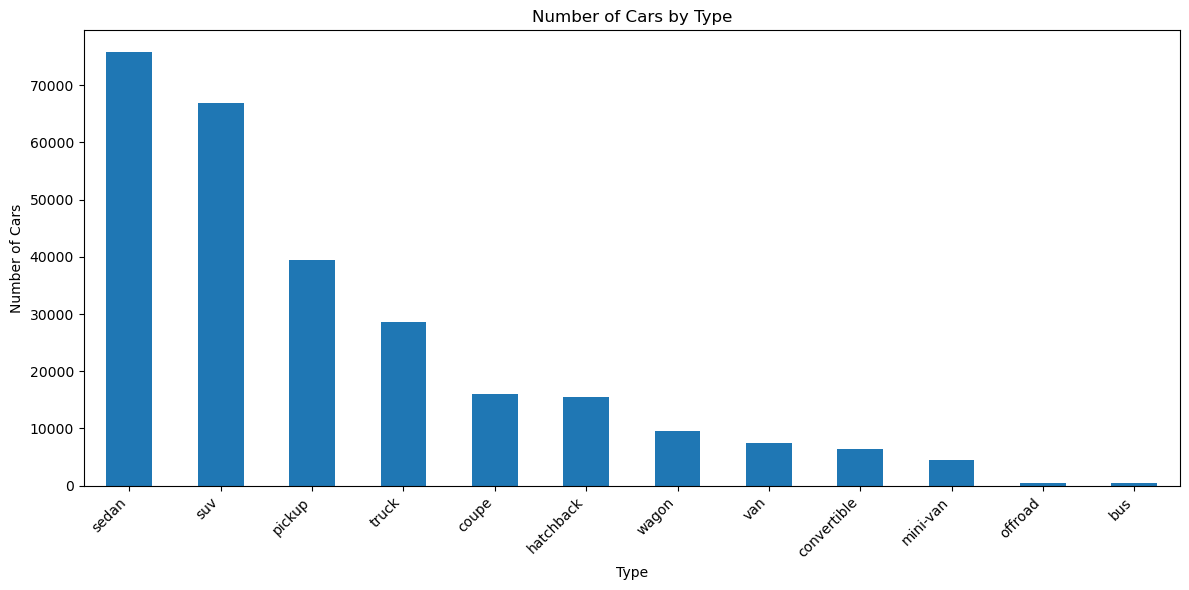

In [25]:
# Plotting number of cars vs type of car 


counts = df_clean['type'].value_counts()

# Plot
plt.figure(figsize=(12,6))
counts.plot(kind='bar')

plt.xlabel("Type")
plt.ylabel("Number of Cars")
plt.title("Number of Cars by Type")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("./images/cars_type.png", dpi=300)
plt.show()

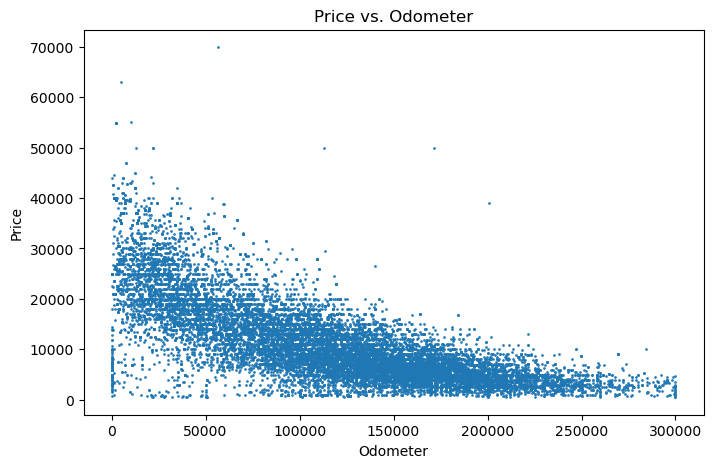

In [26]:
toyota_df = df_clean[df_clean["manufacturer"].str.lower() == "honda"]

plt.figure(figsize=(8,5))

plt.scatter(
    toyota_df["odometer"],
    toyota_df["price"],
    s=1,         # tiny dots
    alpha=0.9   # very transparent
)

plt.xlabel("Odometer")
plt.ylabel("Price")
plt.title("Price vs. Odometer")

plt.ticklabel_format(style='plain', axis='both')

plt.savefig("./images/price_vs_odometer.png", dpi=300)
plt.show()

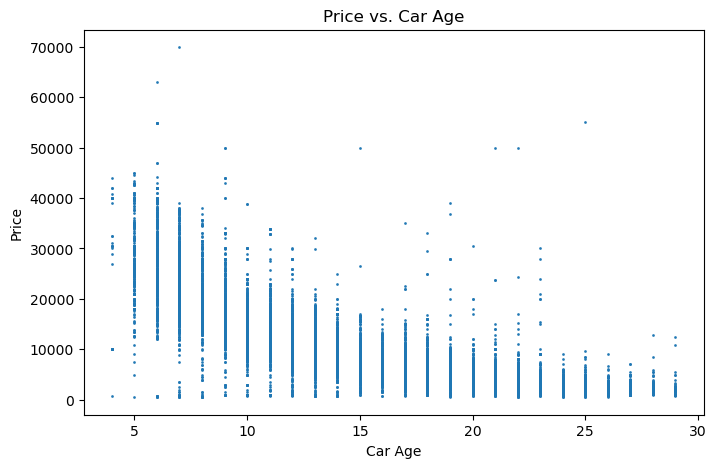

In [27]:


age_filtered_df = toyota_df[toyota_df["car_age"] < 30]
plt.figure(figsize=(8,5))

plt.scatter(
    age_filtered_df ["car_age"],
    age_filtered_df ["price"],
    s=1,         # tiny dots
    alpha=0.9   # very transparent
)

plt.xlabel("Car Age")
plt.ylabel("Price")
plt.title("Price vs. Car Age")

plt.ticklabel_format(style='plain', axis='both')

plt.savefig("./images/price_vs_carAge.png", dpi=300)
plt.show()